# Energy system model of the Spain

In [81]:
import calliope
import pandas as pd

calliope.set_log_verbosity("INFO", include_solver_output=True)

# 1. Reference case
## 1.1. Create and solve the model

In [82]:
model = calliope.read_yaml('model/model.yaml')

[2025-12-08 15:22:34] INFO     Math init | loading pre-defined math.
[2025-12-08 15:22:34] INFO     Math init | loading math files {'milp', 'spores', 'storage_inter_cluster', 'base', 'operate'}.
[2025-12-08 15:22:34] INFO     Model: preprocessing data
[2025-12-08 15:22:34] INFO     Math build | building applied math with ['base', 'operate'].
[2025-12-08 15:22:35] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:22:35] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:22:35] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:22:35] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:22:35] INFO     Model: initialisation complete


In [83]:
model.inputs.sink_use_equals.to_series().dropna()

timesteps            nodes  techs       
2024-10-01 00:00:00  NLD    demand_power    23513.333333
2024-10-01 01:00:00  NLD    demand_power    22478.083333
2024-10-01 02:00:00  NLD    demand_power    21627.416667
2024-10-01 03:00:00  NLD    demand_power    21228.416667
2024-10-01 04:00:00  NLD    demand_power    21190.583333
                                                ...     
2025-09-30 19:00:00  NLD    demand_power    29335.833333
2025-09-30 20:00:00  NLD    demand_power    31345.000000
2025-09-30 21:00:00  NLD    demand_power    30769.416667
2025-09-30 22:00:00  NLD    demand_power    27631.916667
2025-09-30 23:00:00  NLD    demand_power    24969.083333
Name: sink_use_equals, Length: 8759, dtype: float64

In [84]:
model.build()
model.solve()

[2025-12-08 15:22:39] INFO     Model: backend build starting
[2025-12-08 15:22:39] INFO     Optimisation Model | parameters/lookups | Generated.
[2025-12-08 15:22:42] INFO     Optimisation Model | variables | Generated.
[2025-12-08 15:22:43] INFO     Optimisation Model | global_expressions | Generated.
[2025-12-08 15:22:48] INFO     Optimisation Model | constraints | Generated.
[2025-12-08 15:22:48] INFO     Optimisation Model | piecewise_constraints | Generated.
[2025-12-08 15:22:49] INFO     Optimisation Model | objectives | Generated.
[2025-12-08 15:22:49] INFO     Model: backend build complete
[2025-12-08 15:22:53] INFO     Optimisation model | starting model in base mode.
[2025-12-08 15:22:59] DEBUG    Read LP format model from file C:\Users\yaowa\AppData\Local\Temp\tmp7lpxyq0p.pyomo.lp
Reading time = 0.50 seconds
x1: 210208 rows, 140144 columns, 394141 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 6
Set parameter Method to value 2
Set parameter Crossove

## 1.2. Check of the results

In [85]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

nodes carriers           timesteps system_balance
0   NLD    power 2024-10-01 00:00:00       0.012627
1   NLD    power 2024-10-01 01:00:00       0.012627
2   NLD    power 2024-10-01 02:00:00          0.012
3   NLD    power 2024-10-01 03:00:00          0.012
4   NLD    power 2024-10-01 04:00:00          0.012

<Axes: >

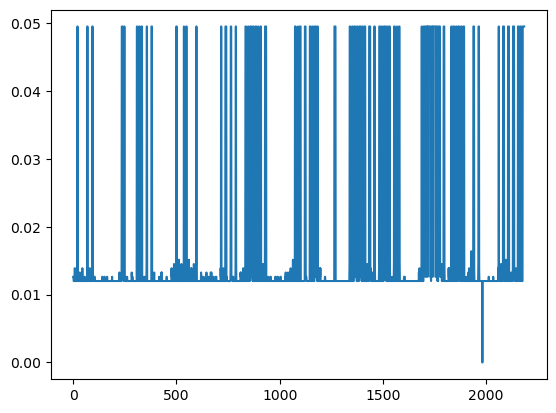

In [137]:
# Create a Date Range to select October to inspect visually
days_of_interest = pd.date_range('2024-10-01','2024-12-31',freq='h') 
# Plot the days of interest
balance_price['system_balance'].loc[balance_price['timesteps'].isin(days_of_interest)].plot()

We need to determine which technology's marginal cost serves as the shadow price for market balancing.

In [119]:
variable_costs = model.results.cost_operation_variable.to_series().dropna()
generation = model.results.flow_out.to_series().dropna()
# hour and the marginal cost of the marginal generator in the merit order
marginal_generation_costs = variable_costs/generation

# tranform to a DataFrame
marginal_generation_costs = marginal_generation_costs.reset_index()

# change column name '0' to 'marginal_generation_cost'
marginal_generation_costs = marginal_generation_costs.rename(columns={0: 'marginal_generation_cost'})
marginal_generation_costs.head()


nodes techs     costs           timesteps carriers  marginal_generation_cost
0   NLD  ccgt  monetary 2024-10-01 00:00:00    power                  0.049503
1   NLD  ccgt  monetary 2024-10-01 01:00:00    power                  0.049503
2   NLD  ccgt  monetary 2024-10-01 02:00:00    power                  0.049503
3   NLD  ccgt  monetary 2024-10-01 03:00:00    power                  0.049503
4   NLD  ccgt  monetary 2024-10-01 04:00:00    power                  0.049503

In [120]:
# Merge marginal generation costs with balance price
merged = marginal_generation_costs.merge(
    balance_price,
    on=['nodes', 'carriers', 'timesteps'],
    how='inner'
)
merged.head()

nodes techs     costs           timesteps carriers  \
0   NLD  ccgt  monetary 2024-10-01 00:00:00    power   
1   NLD  ccgt  monetary 2024-10-01 01:00:00    power   
2   NLD  ccgt  monetary 2024-10-01 02:00:00    power   
3   NLD  ccgt  monetary 2024-10-01 03:00:00    power   
4   NLD  ccgt  monetary 2024-10-01 04:00:00    power   

   marginal_generation_cost system_balance  
0                  0.049503       0.012627  
1                  0.049503       0.012627  
2                  0.049503          0.012  
3                  0.049503          0.012  
4                  0.049503          0.012

In [121]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61313 entries, 0 to 61312
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   nodes                     61313 non-null  object        
 1   techs                     61313 non-null  object        
 2   costs                     61313 non-null  object        
 3   timesteps                 61313 non-null  datetime64[ns]
 4   carriers                  61313 non-null  object        
 5   marginal_generation_cost  52346 non-null  float64       
 6   system_balance            61313 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.3+ MB


In [122]:
# turn system_balance and marginal_generation_cost into float type
merged['system_balance'] = merged['system_balance'].astype(float)
merged['marginal_generation_cost'] = merged['marginal_generation_cost'].astype(float)
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61313 entries, 0 to 61312
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   nodes                     61313 non-null  object        
 1   techs                     61313 non-null  object        
 2   costs                     61313 non-null  object        
 3   timesteps                 61313 non-null  datetime64[ns]
 4   carriers                  61313 non-null  object        
 5   marginal_generation_cost  52346 non-null  float64       
 6   system_balance            61313 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 3.3+ MB


In [123]:
# Compute absolute difference between marginal cost and price
merged['diff'] = (merged['marginal_generation_cost'] - merged['system_balance']).abs()

# Show the technology with the smallest difference for each timestep and node
marginal_tech = (
    merged.sort_values('diff')
          .groupby(['timesteps', 'nodes'], as_index=False)
          .first()[['timesteps', 'nodes', 'techs',
                    'marginal_generation_cost', 'system_balance', 'diff']]
)
marginal_tech.head()


timesteps nodes    techs  marginal_generation_cost  \
0 2024-10-01 00:00:00   NLD  nuclear                  0.012627   
1 2024-10-01 01:00:00   NLD  nuclear                  0.012627   
2 2024-10-01 02:00:00   NLD    hydro                  0.012000   
3 2024-10-01 03:00:00   NLD    hydro                  0.012000   
4 2024-10-01 04:00:00   NLD    hydro                  0.012000   

   system_balance          diff  
0        0.012627  3.134859e-10  
1        0.012627  4.956710e-09  
2        0.012000  1.851205e-10  
3        0.012000  1.048244e-10  
4        0.012000  8.624271e-11

In [130]:
tech_colors = {
    "load_shedding": "#000000",
    "ccgt": "#E37A72",
    "nuclear": "#F3007A",
    "hydro": "#7900f3",
    "solar_pv": "#F9D956",
    "wind_onshore": "#56F9C0",
    "wind_offshore": "#56CBF9"
}

In [138]:
# display timesteps in days_of_interest only
marginal_tech_month = marginal_tech[marginal_tech['timesteps'].isin(days_of_interest)]
marginal_tech_month

timesteps nodes    techs  marginal_generation_cost  \
0    2024-10-01 00:00:00   NLD  nuclear                  0.012627   
1    2024-10-01 01:00:00   NLD  nuclear                  0.012627   
2    2024-10-01 02:00:00   NLD    hydro                  0.012000   
3    2024-10-01 03:00:00   NLD    hydro                  0.012000   
4    2024-10-01 04:00:00   NLD    hydro                  0.012000   
...                  ...   ...      ...                       ...   
2180 2024-12-30 20:00:00   NLD     ccgt                  0.049503   
2181 2024-12-30 21:00:00   NLD     ccgt                  0.049503   
2182 2024-12-30 22:00:00   NLD     ccgt                  0.049503   
2183 2024-12-30 23:00:00   NLD     ccgt                  0.049503   
2184 2024-12-31 00:00:00   NLD     ccgt                  0.049503   

      system_balance          diff  
0           0.012627  3.134859e-10  
1           0.012627  4.956710e-09  
2           0.012000  1.851205e-10  
3           0.012000  1.048244e-10  
4           0.012000  8.624271e-11  
...              ...           ...  
2180        0.049503  1.512068e-11  
2181        0.049503  1.529196e-11  
2182        0.049503  2.532461e-11  
2183        0.049503  5.407990e-11  
2184        0.049503  2.075890e-10  

[2185 rows x 6 columns]

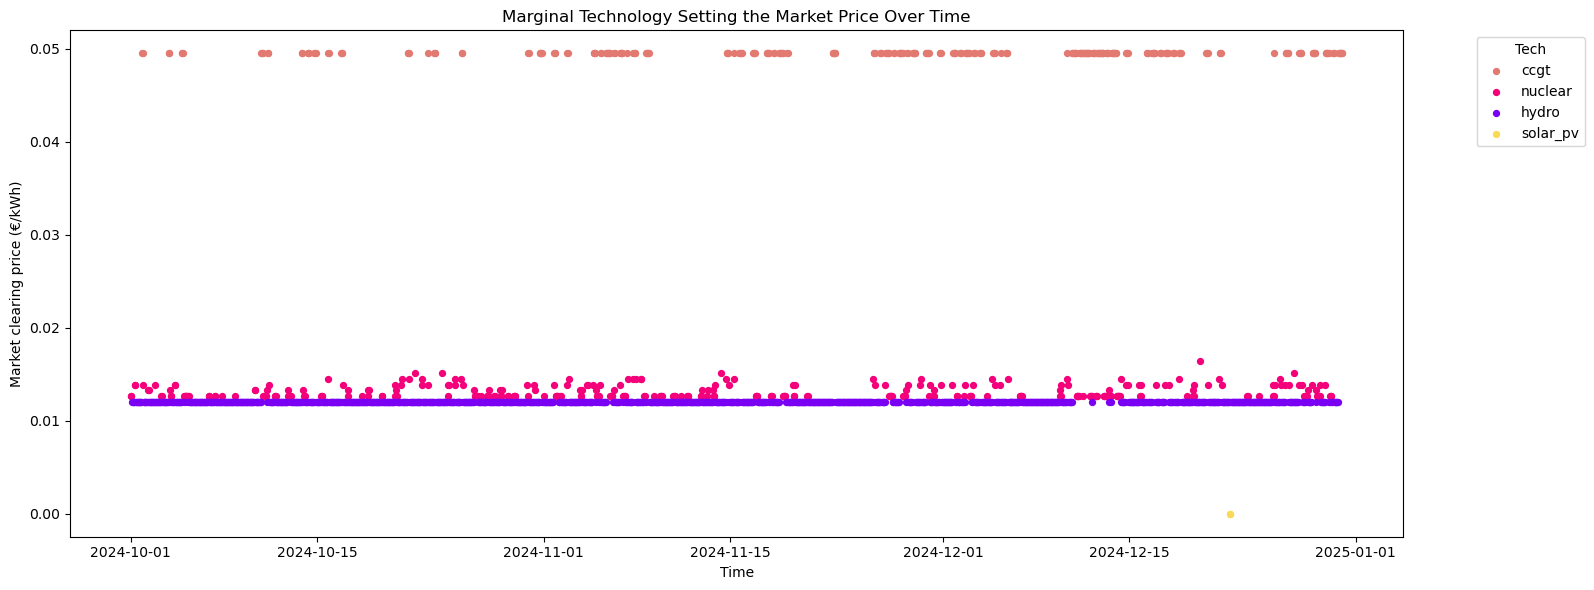

In [139]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))

for tech, color in tech_colors.items():
    df_t = marginal_tech_month[marginal_tech_month['techs'] == tech]
    if len(df_t) > 0:
        plt.scatter(df_t['timesteps'], df_t['system_balance'],
                    s=18, color=color, label=tech)
        
plt.xlabel("Time")
plt.ylabel("Market clearing price (€/kWh)")
plt.title("Marginal Technology Setting the Market Price Over Time")
plt.legend(title="Tech", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


techs
hydro       1547
nuclear      326
ccgt         310
solar_pv       2
Name: count, dtype: int64
techs
hydro       0.708009
nuclear     0.149199
ccgt        0.141876
solar_pv    0.000915
Name: share, dtype: float64


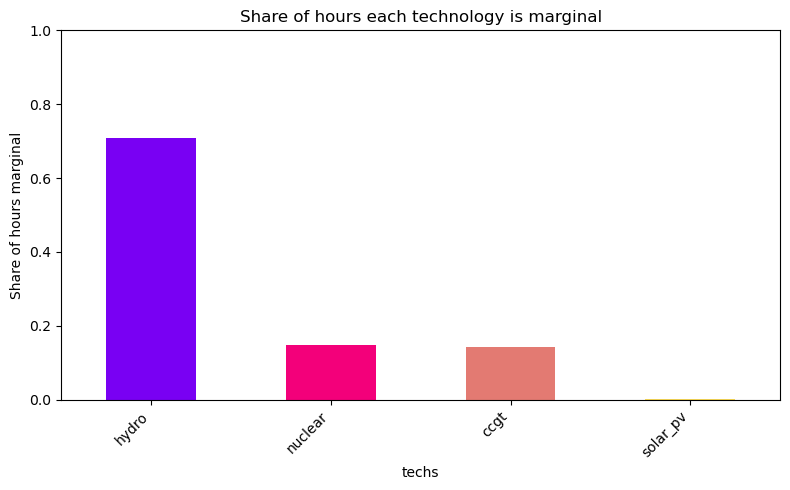

In [141]:
# count how many hours each tech is marginal
freq = marginal_tech_month['techs'].value_counts().sort_values(ascending=False)
print(freq)
share = (freq / freq.sum()).rename('share')
print(share)

fig, ax = plt.subplots(figsize=(8,5))
share.plot(
    kind='bar',
    ax=ax,
    color=[tech_colors.get(tech, 'gray') for tech in share.index]   # map colors
)

ax.set_ylabel('Share of hours marginal')
ax.set_ylim(0, 1)
ax.set_title('Share of hours each technology is marginal')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


We see that CCGT, whose marginal generation costs match the shadow price, is the marginal generator. Nuclear isn't used; if it were, the shadow price would be higher and equal to its marginal cost. This can be double-checked by looking at the dispatch plots.

## 1.3. Export the results for further analysis at any later moment

In [91]:
# It is helpful to store the model results as a whole in NetCDF format, which Calliope can import back
# at any later time. 
model.to_netcdf('results/default_results.nc')

In [93]:
# Alternatively, results can be exported as a series of .csv files for inspection and analysis in Excel or
# other software that may benefit from .csv data
model.to_csv('results/default_results_csv')

## 1.4. Produce some visualisations

In this example, we provide some pre-made plotting functionalities in the 'plotting_utilities.py' file, which you can import and apply as well as use as an example for making your own custom plots.

In [94]:
# Import some pre-made plotting functionalities as an example. You can use these, make your own, or simply
# create plots with your favourite Python library or non-Python tool, such as Excel
from plotting_utilities import plot_dispatch,plot_load_duration_curve

In [95]:
# Dispatch plots can be generated directly from the saved model results
plot_dispatch(model_path='results/default_results.nc', plot_export_path='results/default_dispatch.html')

[2025-12-08 15:23:38] INFO     Model: preprocessing data (reentry)
[2025-12-08 15:23:38] INFO     Math build | building applied math with ['base', 'operate'].
[2025-12-08 15:23:38] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:23:38] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:23:38] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:23:38] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:23:38] INFO     Model: initialisation complete


In [96]:
# For generating load duration curves (LDCs), instead, we first need to import back the model results,
# then extract the time-varing variable of interest
model = calliope.read_netcdf('results/default_results.nc')

[2025-12-08 15:24:51] INFO     Model: preprocessing data (reentry)
[2025-12-08 15:24:51] INFO     Math build | building applied math with ['base', 'operate'].
[2025-12-08 15:24:51] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:24:51] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:24:51] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:24:51] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-08 15:24:51] INFO     Model: initialisation complete


In [97]:
# Suppose we want to plot the LDC of the dispatch of the CCGT power plant
ccgt_dispatch = model.results.flow_out.sel(techs='ccgt').to_series().dropna()
ccgt_dispatch.head()

nodes  carriers  timesteps          
NLD    power     2024-10-01 00:00:00    0.000006
                 2024-10-01 01:00:00    0.000006
                 2024-10-01 02:00:00    0.000006
                 2024-10-01 03:00:00    0.000006
                 2024-10-01 04:00:00    0.000006
Name: flow_out, dtype: float64

In [98]:
plot_load_duration_curve(dataframe=ccgt_dispatch.to_frame(), 
                         plot_export_path='results/default_ccgt_ldc.html', 
                         y_label='Flow out (MWh)')

In [57]:
# Or we may want the LDC of the shadow price, which we calculated earlier
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')

In [58]:
# Obtain demand from input
demand = model.inputs.sink_use_equals.sel(techs='demand_power').to_series().dropna()

# Get the dispatch of renewables
solar_pv_dispatch = model.results.flow_out.sel(techs='solar_pv').to_series().dropna()
wind_onshore_dispatch = model.results.flow_out.sel(techs='wind_onshore').to_series().dropna()

# Calculate the residual load (load minus renewable generation)
residual_load = demand - (solar_pv_dispatch + wind_onshore_dispatch)
residual_load.head()

timesteps            nodes  carriers
2024-10-01 00:00:00  NLD    power       18482.351060
2024-10-01 01:00:00  NLD    power       17124.547769
2024-10-01 02:00:00  NLD    power       15988.931413
2024-10-01 03:00:00  NLD    power       15260.833297
2024-10-01 04:00:00  NLD    power       14931.385135
dtype: float64

In [59]:
# Plot the LDC of the residual load
plot_load_duration_curve(dataframe=residual_load.to_frame(name='Residual Load (MWh)'),
                         plot_export_path='results/default_residual_load.html',
                         y_label='Residual Load (MWh)')


## 1.5. Cost recovery

In [74]:
gen_techs = ['solar_pv','wind_onshore', 'hydro', 'ccgt', 'nuclear'] 

In [75]:
# Flow out for all gen techs in one go
dispatch = (
    model.results.flow_out
    .sel(techs=gen_techs, carriers='power')   # carriers only if present
    .to_series()                              # -> Series with index (nodes, techs, timesteps)
    .unstack('techs')                         # techs become columns
    .reset_index()                            # timesteps as column, keep nodes
)

dispatch.head()


techs nodes           timesteps    solar_pv  wind_onshore         hydro  \
0       NLD 2024-10-01 00:00:00  549.950238   4481.032035  17076.999662   
1       NLD 2024-10-01 01:00:00  530.303485   4823.232080  17076.999661   
2       NLD 2024-10-01 02:00:00  493.366528   5145.118725  15988.931086   
3       NLD 2024-10-01 03:00:00  459.898204   5507.685166  15260.832970   
4       NLD 2024-10-01 04:00:00  331.850088   5927.348110  14931.384808   

techs      ccgt      nuclear  
0      0.000006  1405.351409  
1      0.000006    47.548118  
2      0.000006     0.000338  
3      0.000006     0.000338  
4      0.000006     0.000338

In [76]:
# Shadow price dataframe
balance_price = (
    model.results.shadow_price_system_balance
    .to_series().reset_index()
)
balance_price

# Merge price into dispatch
df = balance_price.merge(dispatch, on='timesteps', how='left')
df.head()

nodes_x carriers           timesteps  shadow_price_system_balance nodes_y  \
0     NLD    power 2024-10-01 00:00:00                     0.012627     NLD   
1     NLD    power 2024-10-01 01:00:00                     0.012627     NLD   
2     NLD    power 2024-10-01 02:00:00                     0.012000     NLD   
3     NLD    power 2024-10-01 03:00:00                     0.012000     NLD   
4     NLD    power 2024-10-01 04:00:00                     0.012000     NLD   

     solar_pv  wind_onshore         hydro      ccgt      nuclear  
0  549.950238   4481.032035  17076.999662  0.000006  1405.351409  
1  530.303485   4823.232080  17076.999661  0.000006    47.548118  
2  493.366528   5145.118725  15988.931086  0.000006     0.000338  
3  459.898204   5507.685166  15260.832970  0.000006     0.000338  
4  331.850088   5927.348110  14931.384808  0.000006     0.000338

In [77]:
# Revenue per tech = price * dispatch (hourly)
for tech in gen_techs:
    df[f'{tech}_revenue'] = df[tech] * df['shadow_price_system_balance']

# Total (modelled-period) revenue per tech
revenue = df[[f'{t}_revenue' for t in gen_techs]].sum()
revenue.index = revenue.index.str.replace('_revenue', '', regex=False)
revenue.name = 'revenue'
revenue

solar_pv        6.655444e+05
wind_onshore    8.569423e+05
hydro           2.007011e+06
ccgt            1.670132e+05
nuclear         4.181056e+05
Name: revenue, dtype: float64

In [78]:
cost = (
    model.results.cost
    .sel(techs=gen_techs)   # we only care about these
    .sum('nodes')           # if you only have one node, this just drops the dim
    .to_series()
)
cost = cost.droplevel('costs')                # or just drop the level
cost.name = 'cost'
cost


techs
solar_pv        5.632421e+02
wind_onshore    8.459306e+04
hydro           1.309804e+06
ccgt            1.670132e+05
nuclear         1.857327e+05
Name: cost, dtype: float64

In [79]:
# calculate profit and cost recovery ratio
covery = pd.concat([revenue, cost], axis=1)
covery['profit'] = covery['revenue'] - covery['cost'] # >0 means revenue covers cost
covery['cost_recovery_ratio'] = covery['revenue'] / covery['cost']  # >1 means full recovery
covery

revenue          cost         profit  cost_recovery_ratio
solar_pv      6.655444e+05  5.632421e+02  664981.194336          1181.631236
wind_onshore  8.569423e+05  8.459306e+04  772349.223004            10.130172
hydro         2.007011e+06  1.309804e+06  697206.622374             1.532298
ccgt          1.670132e+05  1.670132e+05      -0.001833             1.000000
nuclear       4.181056e+05  1.857327e+05  232372.890977             2.251115

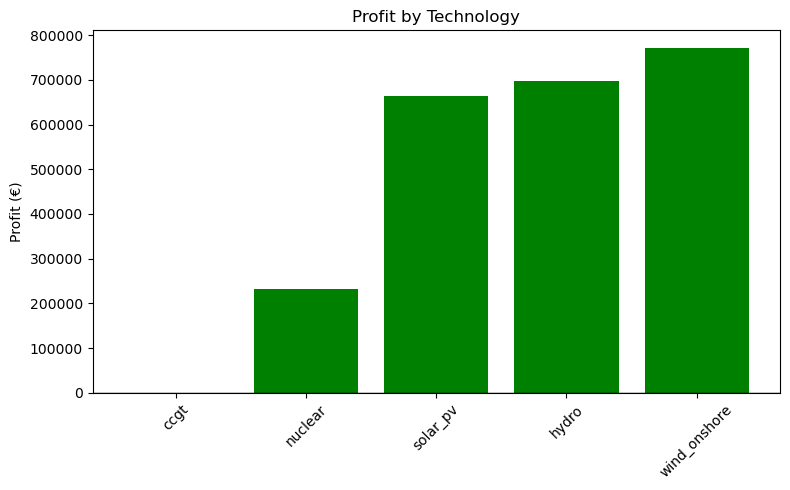

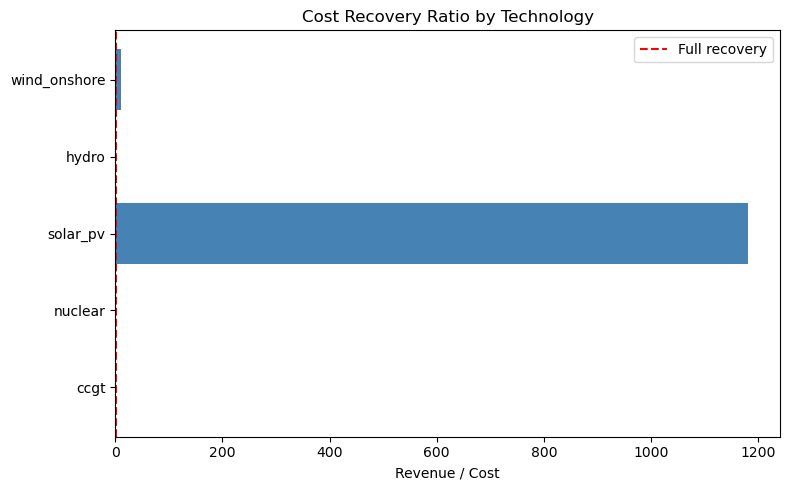

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

covery_sorted = covery.sort_values("profit")   # optional sorting
techs = covery_sorted.index

# --- FIGURE 1: PROFIT ---
plt.figure(figsize=(8,5))
colors = ['green' if p >= 0 else 'red' for p in covery_sorted['profit']]
plt.bar(techs, covery_sorted['profit'], color=colors)
plt.axhline(0, color='black', linewidth=1)
plt.title("Profit by Technology")
plt.ylabel("Profit (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- FIGURE 2: COST RECOVERY RATIO ---
plt.figure(figsize=(8,5))
plt.barh(techs, covery_sorted['cost_recovery_ratio'], color='steelblue')
plt.axvline(1.0, color='red', linestyle='--', label='Full recovery')
plt.title("Cost Recovery Ratio by Technology")
plt.xlabel("Revenue / Cost")
plt.legend()
plt.tight_layout()
plt.show()


## 1.6. CO2 emissions

In [66]:
import pandas as pd
import matplotlib.pyplot as plt


# to get hourly generation for all techs, power carrier only
power_gen = model.results.flow_out.sel(carriers="power")   # (nodes, techs, timesteps)

In [67]:
# emission factors (tCO2 per MWh of electricity)
emission_factors = {
    "ccgt": 0.42,   # only ccgt emits co2 emissions https://www.climatiq.io/data/emission-factor/7bfab478-b1e7-4ded-9907-9f200b40f2cb
}

In [68]:
# hourly emissions by tech (keep dict for possible future extra techs but this case only involves ccgt)
hourly_emissions_by_tech = {}
total_emissions_by_tech = {}

for tech, ef in emission_factors.items():
    # hourly generation for this tech (sum over nodes)
    gen_tech = power_gen.sel(techs=tech).sum(dim="nodes")      # (timesteps), MWh/h

    # hourly emissions (tCO2/h)
    emis_tech = gen_tech * ef                                  # DataArray over timesteps
    hourly_emissions_by_tech[tech] = emis_tech

    # total emissions over whole period
    total_emissions_by_tech[tech] = float(emis_tech.sum())     # tCO2


In [69]:
# Total across all emitting techs
total_emissions_t = sum(total_emissions_by_tech.values())

print("CO2 emissions by tech:")
for tech, val in total_emissions_by_tech.items():
    print(f"  {tech}: {val:,.2f} tCO2")

print(f"\nTotal CO2 emissions: {total_emissions_t:,.2f} tCO2")
print(f"Total CO2 emissions: {total_emissions_t/1e6:.3f} MtCO2")

CO2 emissions by tech:
  ccgt: 1,416,983.96 tCO2

Total CO2 emissions: 1,416,983.96 tCO2
Total CO2 emissions: 1.417 MtCO2


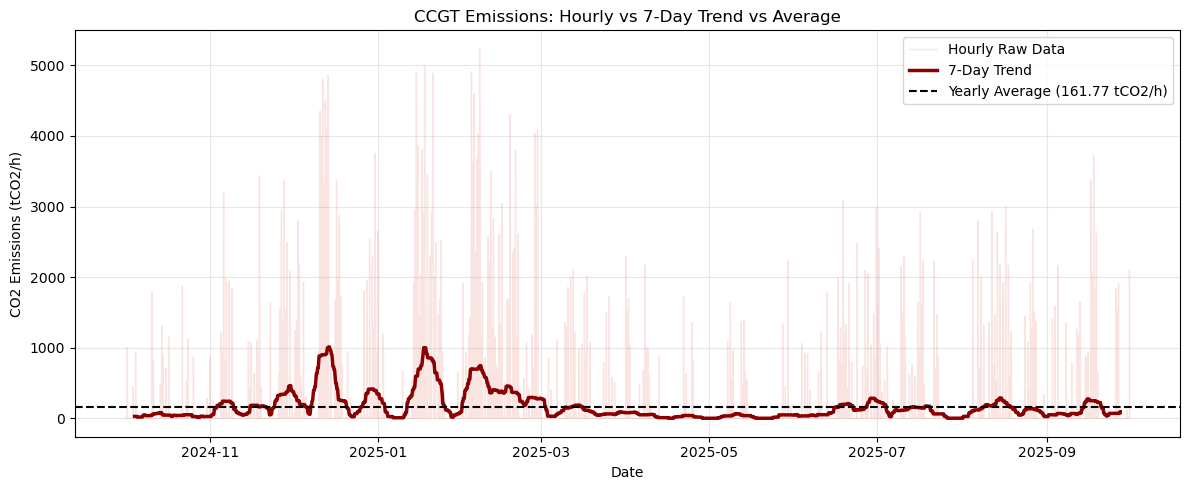

In [70]:
#plot
# convert to pandas Series with datetime index
ccgt_emissions = hourly_emissions_by_tech["ccgt"].to_series()
ccgt_emissions.index = pd.to_datetime(ccgt_emissions.index)

# 7-day rolling trend (168 hours)
trend_line = ccgt_emissions.rolling(window=168, center=True).mean()

# average over the whole period
average_val = ccgt_emissions.mean()

plt.figure(figsize=(12, 5))

# raw hourly data (faint)
plt.plot(
    ccgt_emissions.index,
    ccgt_emissions.values,
    color="#E37A72",
    alpha=0.2,
    linewidth=1,
    label="Hourly Raw Data",
)

# 7-day trend
plt.plot(
    trend_line.index,
    trend_line.values,
    color="darkred",
    linewidth=2.5,
    label="7-Day Trend",
)

# average line
plt.axhline(
    y=average_val,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label=f"Yearly Average ({average_val:.2f} tCO2/h)",
)

plt.xlabel("Date")
plt.ylabel("CO2 Emissions (tCO2/h)")
plt.title("CCGT Emissions: Hourly vs 7-Day Trend vs Average")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## compute RES share, scaling factor, and target capacities for scenarios high RE

In [71]:
# to compute RES share, scaling factor, and target capacities for scenarios high RE
# total demand (MWh)
demand = (
    model.inputs.sink_use_equals
    .sel(techs="demand_power")
    .sum()
    .item()
)

renew_techs = ["wind_onshore", "solar_pv"]

gen_res = (
    model.results.flow_out
    .sel(techs=renew_techs, carriers="power")
    .sum()
    .item()
)

gen_all = (
    model.results.flow_out
    .sel(carriers="power")
    .sum()
    .item()
)

res_share = gen_res / gen_all
print(f"Current RES share: {res_share*100:.1f} %")

Current RES share: 46.2 %


In [72]:
target_share = 0.81
scale = target_share / res_share if gen_res > 0 else 1.0
print("Approximate RE scaling factor:", scale)

# Get baseline wind capacity (MW)
cap_wind_base = (
    model.inputs.flow_cap
    .sel(nodes="NLD", techs="wind_onshore")
    .item()
)

# Get baseline solar capacity (MW)
cap_solar_base = (
    model.inputs.flow_cap
    .sel(nodes="NLD", techs="solar_pv")
    .item()
)

cap_wind_target = cap_wind_base * scale
cap_solar_target = cap_solar_base * scale

print("Base wind:", cap_wind_base, "-> Target:", cap_wind_target)
print("Base solar:", cap_solar_base, "-> Target:", cap_solar_target)


Approximate RE scaling factor: 1.7534827098043257
Base wind: 33008.0 -> Target: 57878.957285221186
Base solar: 40945.0 -> Target: 71796.34955293812


# 2. Renewables growth case
## 2.1. Reload the model with a scenario that forces a higher capacity of renewables and re-solve

In [33]:
model = calliope.read_yaml('model/model.yaml',scenario='more_renewables')

[2025-12-05 18:06:59] INFO     Loading overrides from scenario: more_renewables 
[2025-12-05 18:06:59] INFO     (scenarios, more_renewables ) | Applying the following overrides: ['higher_solar', 'higher_wind'].
[2025-12-05 18:06:59] INFO     Math init | loading pre-defined math.
[2025-12-05 18:06:59] INFO     Math init | loading math files {'operate', 'storage_inter_cluster', 'base', 'milp', 'spores'}.


[2025-12-05 18:06:59] INFO     Model: preprocessing data
[2025-12-05 18:06:59] INFO     Math build | building applied math with ['base', 'operate'].
[2025-12-05 18:06:59] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-05 18:06:59] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-05 18:07:00] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-05 18:07:00] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-05 18:07:00] INFO     Model: initialisation complete


In [34]:
model.build()
model.solve()

[2025-12-05 18:07:02] INFO     Model: backend build starting
[2025-12-05 18:07:02] INFO     Optimisation Model | parameters/lookups | Generated.
[2025-12-05 18:07:03] INFO     Optimisation Model | variables | Generated.
[2025-12-05 18:07:03] INFO     Optimisation Model | global_expressions | Generated.
[2025-12-05 18:07:06] INFO     Optimisation Model | constraints | Generated.
[2025-12-05 18:07:06] INFO     Optimisation Model | piecewise_constraints | Generated.
[2025-12-05 18:07:06] INFO     Optimisation Model | objectives | Generated.
[2025-12-05 18:07:06] INFO     Model: backend build complete
[2025-12-05 18:07:09] INFO     Optimisation model | starting model in base mode.
[2025-12-05 18:07:12] DEBUG    Read LP format model from file C:\Users\athaa\AppData\Local\Temp\tmpzqc07oez.pyomo.lp
Reading time = 0.26 seconds
x1: 192690 rows, 122626 columns, 359105 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 6
Set parameter Method to value 2
Set parameter Crossove

In [35]:
model.to_netcdf('results/more_vres.nc')

## 2.1. Visualise the change in the system operation and the impact on prices

In [37]:
# Dispatch plots can be generated directly from the saved model results
plot_dispatch(model_path='results/more_vres.nc', plot_export_path='results/more_vres.html')

[2025-12-05 18:07:24] INFO     Model: preprocessing data (reentry)
[2025-12-05 18:07:24] INFO     Math build | building applied math with ['base', 'operate'].
[2025-12-05 18:07:24] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-05 18:07:24] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-05 18:07:24] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-12-05 18:07:24] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-12-05 18:07:24] INFO     Model: initialisation complete


AttributeError: 'Dataset' object has no attribute 'flow_out'

In [38]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

nodes carriers           timesteps system_balance
0   NLD    power 2024-10-01 00:00:00            NaN
1   NLD    power 2024-10-01 01:00:00            NaN
2   NLD    power 2024-10-01 02:00:00            NaN
3   NLD    power 2024-10-01 03:00:00            NaN
4   NLD    power 2024-10-01 04:00:00            NaN

In [39]:
# LDC of the shadow price, which we calculated earlier
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')

# 3. Nuclear phase out
## 3.1 Reload the model with a scenario that forces a lower capacity of CCGT and re-solve

In [ ]:
model = calliope.read_yaml('model/model.yaml',scenario='generation_outage')

[2025-11-10 17:38:31] INFO     Loading overrides from scenario: generation_outage 
[2025-11-10 17:38:31] INFO     (scenarios, generation_outage ) | Applying the following overrides: ['lower_ccgt'].
[2025-11-10 17:38:31] INFO     Math init | loading pre-defined math.
[2025-11-10 17:38:31] INFO     Math init | loading math files {'operate', 'base', 'storage_inter_cluster', 'milp', 'spores'}.
[2025-11-10 17:38:31] INFO     Model: preprocessing data
[2025-11-10 17:38:31] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:38:32] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:32] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:32] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:32] INFO     input data `name` not defined in mo

In [ ]:
model.build()
model.solve()

[2025-11-10 17:38:32] INFO     Model: backend build starting
[2025-11-10 17:38:32] INFO     Optimisation Model | parameters/lookups | Generated.
[2025-11-10 17:38:32] INFO     Optimisation Model | variables | Generated.
[2025-11-10 17:38:33] INFO     Optimisation Model | global_expressions | Generated.
[2025-11-10 17:38:34] INFO     Optimisation Model | constraints | Generated.
[2025-11-10 17:38:34] INFO     Optimisation Model | piecewise_constraints | Generated.
[2025-11-10 17:38:34] INFO     Optimisation Model | objectives | Generated.
[2025-11-10 17:38:34] INFO     Model: backend build complete
[2025-11-10 17:38:34] INFO     Optimisation model | starting model in base mode.
[2025-11-10 17:38:35] DEBUG    Read LP format model from file /tmp/tmp_383qm9w.pyomo.lp
Reading time = 0.02 seconds
x1: 15620 rows, 10416 columns, 28264 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 6
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter Feasi

In [ ]:
model.to_netcdf('results/less_generation.nc')

## 3.1. Visualise the change in the system operation and the impact on prices

[2025-11-10 17:38:36] INFO     Model: preprocessing data (reentry)
[2025-11-10 17:38:36] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:38:36] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     Model: initialisation complete


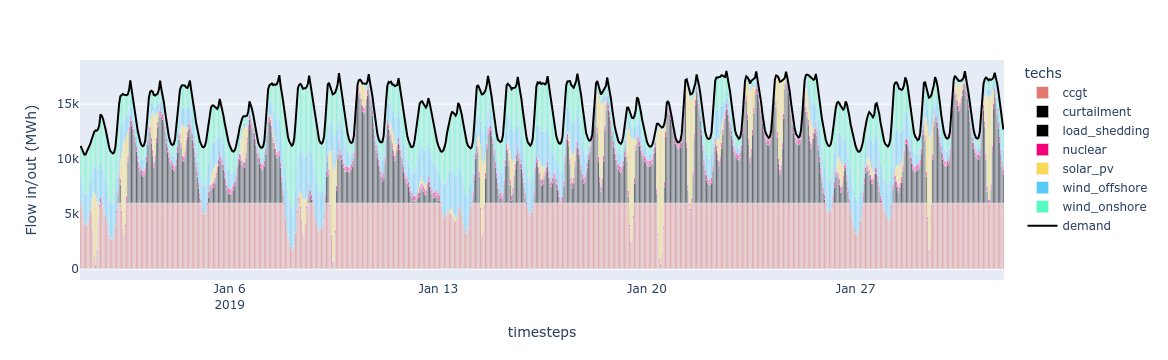

In [ ]:
# Dispatch plots can be generated directly from the saved model results
plot_dispatch(model_path='results/less_generation.nc', plot_export_path='results/less_generation.html')

In [ ]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

nodes carriers           timesteps system_balance
0   NLD    power 2019-01-01 00:00:00       0.022375
1   NLD    power 2019-01-01 01:00:00       0.007982
2   NLD    power 2019-01-01 02:00:00       0.007982
3   NLD    power 2019-01-01 03:00:00       0.007982
4   NLD    power 2019-01-01 04:00:00       0.007982

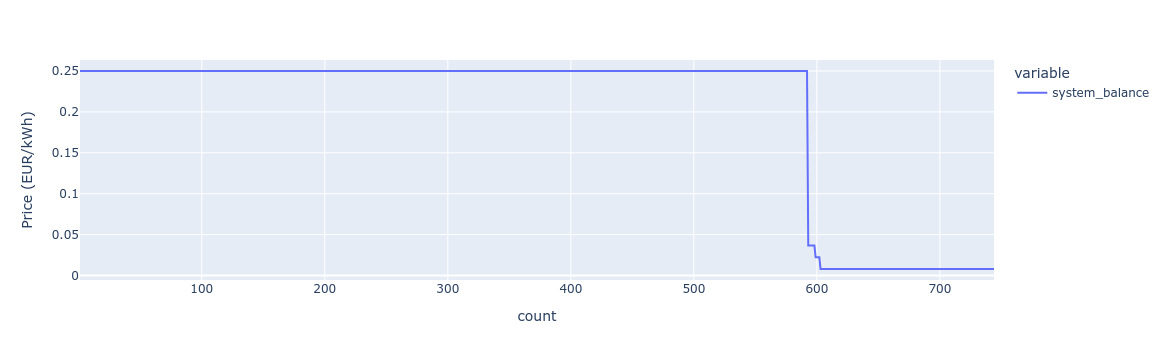

In [ ]:
# LDC of the shadow price, which we calculated earlier
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')